<a href="https://colab.research.google.com/github/NelisLima/data_science/blob/main/4_machine_learning_previsao_de_demanda_entrega_produtos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Projeto de Data Science - Machine Learning</font>

### Previsão de Demanda Para Otimizar a Entrega de Produtos e Uso de Transportadoras</font>

### Instalando e Carregando os Pacotes

In [ ]:
# Imports
import sklearn
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
# Definir a semente para garantir reprodutibilidade
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

### Carregando os Dados e Definindo a Série Temporal

In [ ]:
# Carrega os dados
df_dsa = pd.read_csv('dataset.csv')

In [ ]:
# Shape
df_dsa.shape

(55, 5)

In [ ]:
# Amostra
df_dsa.head()

,ano,otif,lead_time,custo_transporte,indice_rotatividade_estoque
0,1970,11.43,5.63,1980.10,0.15
1,1971,14.59,7.34,1930.63,0.39
2,1972,12.45,6.58,1057.70,2.46
3,1973,11.35,14.45,2881.87,0.73
4,1974,9.05,8.05,1617.81,1.48


In [ ]:
# Amostra
df_dsa.tail()

,ano,otif,lead_time,custo_transporte,indice_rotatividade_estoque
50,2020,11.83,19.40,2518.30,1.69
51,2021,9.33,7.98,1922.75,1.70
52,2022,19.78,13.22,1517.96,1.72
53,2023,18.78,14.22,1617.96,1.73
54,2024,17.48,19.32,1717.96,1.79


In [ ]:
# Define nossa série temporal
indice_rotatividade_estoque = df_dsa['indice_rotatividade_estoque'].values.reshape(-1, 1)

In [ ]:
indice_rotatividade_estoque

array([[ 0.15],
       [ 0.39],
       [ 2.46],
       [ 0.73],
       [ 1.48],
       [ 1.12],
       [ 0.41],
       [ 0.48],
       [ 1.15],
       [ 0.31],
       [ 0.58],
       [ 0.23],
       [ 0.57],
       [ 2.79],
       [ 0.43],
       [ 2.9 ],
       [-0.2 ],
       [ 1.8 ],
       [ 0.  ],
       [ 0.3 ],
       [ 1.72],
       [ 1.1 ],
       [ 2.26],
       [ 0.86],
       [ 2.6 ],
       [-0.17],
       [-0.49],
       [ 2.6 ],
       [ 0.38],
       [-1.  ],
       [ 2.19],
       [ 1.84],
       [ 0.33],
       [-0.38],
       [-2.4 ],
       [ 2.16],
       [ 2.77],
       [-2.45],
       [ 0.82],
       [ 0.64],
       [ 1.3 ],
       [ 0.34],
       [ 0.93],
       [ 0.53],
       [ 0.85],
       [ 0.5 ],
       [ 0.66],
       [ 0.98],
       [ 0.97],
       [ 1.63],
       [ 1.69],
       [ 1.7 ],
       [ 1.72],
       [ 1.73],
       [ 1.79]])

### Função Para Preparar o Dataset Para Treinamento do Modelo

In [ ]:
# Função para criar o dataset para o modelo LSTM com look_back
# O parâmetro look_back define o número de passos no tempo que o modelo usará para fazer cada previsão
def prepara_dados(data, look_back = 1):

    # Inicializa duas listas vazias, X e Y, que conterão as sequências de entrada e saída, respectivamente
    X, Y = [], []

    # Itera pelo conjunto de dados menos o valor de look_back.
    # Isso é feito para evitar índices fora dos limites do array
    for i in range(len(data) - look_back):

        # Coleta uma sequência de dados de tamanho look_back começando no índice i
        a = data[i:(i + look_back), 0]

        # Adiciona a sequência à lista X
        X.append(a)

        # Adiciona o valor imediatamente após a sequência de look_back à lista Y.
        # Esse será nosso valor de saída (target).
        Y.append(data[i + look_back, 0])

    # Converte X e Y para arrays numpy para compatibilidade com a maioria das bibliotecas de aprendizado de máquina
    return np.array(X), np.array(Y)

### Dividindo a Série Temporal em Treino e Teste

In [ ]:
# Dividimos os dados em treinamento e teste (respeitando a ordem cronológica dos dados)
indice = int(len(indice_rotatividade_estoque) * 0.8)
dados_treino, dados_teste = indice_rotatividade_estoque[0:indice, :], indice_rotatividade_estoque[indice:len(indice_rotatividade_estoque), :]

In [ ]:
dados_treino

array([[ 0.15],
       [ 0.39],
       [ 2.46],
       [ 0.73],
       [ 1.48],
       [ 1.12],
       [ 0.41],
       [ 0.48],
       [ 1.15],
       [ 0.31],
       [ 0.58],
       [ 0.23],
       [ 0.57],
       [ 2.79],
       [ 0.43],
       [ 2.9 ],
       [-0.2 ],
       [ 1.8 ],
       [ 0.  ],
       [ 0.3 ],
       [ 1.72],
       [ 1.1 ],
       [ 2.26],
       [ 0.86],
       [ 2.6 ],
       [-0.17],
       [-0.49],
       [ 2.6 ],
       [ 0.38],
       [-1.  ],
       [ 2.19],
       [ 1.84],
       [ 0.33],
       [-0.38],
       [-2.4 ],
       [ 2.16],
       [ 2.77],
       [-2.45],
       [ 0.82],
       [ 0.64],
       [ 1.3 ],
       [ 0.34],
       [ 0.93],
       [ 0.53]])

In [ ]:
dados_teste

array([[0.85],
       [0.5 ],
       [0.66],
       [0.98],
       [0.97],
       [1.63],
       [1.69],
       [1.7 ],
       [1.72],
       [1.73],
       [1.79]])

### Padronização dos Dados

In [ ]:
# Normaliza os dados (requerimento para redes neurais)
scaler = MinMaxScaler(feature_range = (0, 1))

In [ ]:
# Treina e aplica o scaler em treino
# Somente aplica em teste
dados_treino_norm = scaler.fit_transform(dados_treino)
dados_teste_norm = scaler.transform(dados_teste)

### Preparação e Ajuste do Formato dos Dados

In [ ]:
# Criamos os datasets para o modelo LSTM
look_back = 1
X_treino, y_treino = prepara_dados(dados_treino_norm, look_back)
X_teste, y_teste = prepara_dados(dados_teste_norm, look_back)

In [ ]:
# Reshape dos dados para [samples, time steps, features]. Isso é um requerimento do modelo LSTM
X_treino = np.reshape(X_treino, (X_treino.shape[0], X_treino.shape[1], 1))
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

### Arquitetura do Modelo de Machine Learning


https://www.deeplearningbook.com.br/arquitetura-de-redes-neurais-long-short-term-memory/

In [ ]:
# Construindo o modelo LSTM
modelo = tf.keras.models.Sequential([tf.keras.layers.LSTM(50, input_shape = (look_back, 1)),
                                     tf.keras.layers.Dense(1)])

### Compilação do Modelo

In [ ]:
# Compila o modelo
modelo.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

### Treinamento e Avaliação do Modelo

In [ ]:
# Treinamento do modelo
modelo.fit(X_treino, y_treino, epochs = 50, batch_size = 1, verbose = 1)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3253
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1322
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0533
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0519
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0539
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0527
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0514
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0501
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0489
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0477
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0465
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0455
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0444
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0434
Epoch 15/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0425
Epoch 16/50
43/43 ━

In [ ]:
# Fazendo previsões com o modelo
previsao_treino = modelo.predict(X_treino)
previsao_teste = modelo.predict(X_teste)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


In [ ]:
# Transformar de volta para a escala original para calcular o erro
previsao_treino = scaler.inverse_transform(previsao_treino)
y_treino_rescaled = scaler.inverse_transform([y_treino])
previsao_teste = scaler.inverse_transform(previsao_teste)
y_teste_rescaled = scaler.inverse_transform([y_teste])

In [ ]:
# Calcular o RMSE
train_score = np.sqrt(mean_squared_error(y_treino_rescaled[0], previsao_treino[:, 0]))
print(f"\nRMSE em Treino: {train_score:.2f}")


RMSE em Treino: 1.18


In [ ]:
test_score = np.sqrt(mean_squared_error(y_teste_rescaled[0], previsao_teste[:, 0]))
print(f"RMSE em Teste: {test_score:.2f}")

RMSE em Teste: 0.76


### Formatando os Dados Para Visualização

In [ ]:
# Cria um índice para os dados de treino originais, começando em 'look_back'
# e terminando em 'look_back + len(y_treino_rescaled[0])'.
# Este índice será utilizado para associar cada ponto de dado de treino ao seu ano correspondente
# no DataFrame 'df_dsa'.
original_train_data_index = df_dsa['ano'][look_back:look_back + len(y_treino_rescaled[0])]

In [ ]:
# Cria um índice para os dados de teste originais.
# Começa a partir do final dos dados de treino padronizados e vai até o final dos dados de teste padronizados.
# O '2 * look_back' é utilizado para ajustar o índice corretamente.
original_test_data_index = df_dsa['ano'][len(y_treino_rescaled[0]) + 2 * look_back:len(y_treino_rescaled[0]) + 2 * look_back + len(y_teste_rescaled[0])]

In [ ]:
# Cria um índice para os valores previstos em treino, começando em 'look_back'
# e terminando em 'look_back + len(previsao_treino)'.
# Este índice será utilizado para associar cada ponto previsto no conjunto de treino ao seu ano correspondente
# no DataFrame 'df_dsa'.
predicted_train_data_index = df_dsa['ano'][look_back:look_back + len(previsao_treino)]

In [ ]:
# Cria um índice para os valores previstos em teste.
predicted_test_data_index = df_dsa['ano'][len(y_treino_rescaled[0]) + 2 * look_back:len(y_treino_rescaled[0]) + 2 * look_back+len(previsao_teste)]

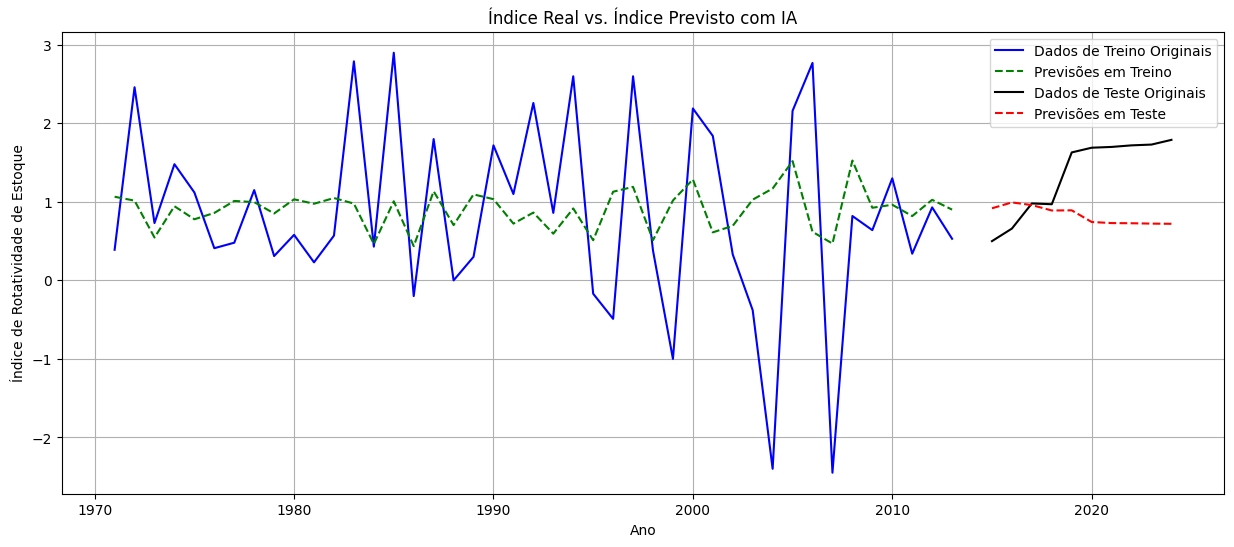

In [ ]:
# Plotar os resultados
plt.figure(figsize = (15, 6))
plt.plot(original_train_data_index,
         y_treino_rescaled[0],
         label = "Dados de Treino Originais",
         color = "blue",
         linestyle = '-')
plt.plot(predicted_train_data_index,
         previsao_treino[:, 0],
         label = "Previsões em Treino",
         color = "green", linestyle='--')
plt.plot(original_test_data_index,
         y_teste_rescaled[0],
         label = "Dados de Teste Originais",
         color = "black",
         linestyle = '-')
plt.plot(predicted_test_data_index,
         previsao_teste[:, 0],
         label = "Previsões em Teste",
         color = "red",
         linestyle = '--')
plt.title("Índice Real vs. Índice Previsto com IA")
plt.xlabel("Ano")
plt.ylabel("Índice de Rotatividade de Estoque")
plt.legend()
plt.grid(True)
plt.show()

### Módulo de Forecast Para Previsões com o Modelo Treinado

In [ ]:
# Usamos a última entrada da série original de teste para fazer a próxima previsão
last_data = dados_teste_norm[-look_back:]
last_data = np.reshape(last_data, (1, look_back, 1))

In [ ]:
# Lista
lista_previsoes = []

In [ ]:
# Loop de Previsão para prever 2 anos (2025 e 2026)
for _ in range(2):

    # Previsão com o modelo (usamos os dados normalizados)
    prediction = modelo.predict(last_data)

    # Adiciona a previsão à lista de previsões
    lista_previsoes.append(prediction[0, 0])

    # Atualiza os dados para incluir a nova previsão e remover o valor mais antigo
    # Isso significa que usaremos a previsão de 2025 para prever o valor de 2026
    last_data = np.roll(last_data, shift = -1)
    last_data[0, look_back - 1, 0] = prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [ ]:
# Transformar de volta para a escala original
lista_previsoes_rescaled = scaler.inverse_transform(np.array(lista_previsoes).reshape(-1, 1))

In [ ]:
print(f"\nPrevisão do Índice de Rotatividade de Estoque Para 2025: {lista_previsoes_rescaled[0, 0]:.2f}")
print(f"Previsão do Índice de Rotatividade de Estoque Para 2026: {lista_previsoes_rescaled[1, 0]:.2f}")


Previsão do Índice de Rotatividade de Estoque Para 2025: 0.71
Previsão do Índice de Rotatividade de Estoque Para 2026: 0.95
